# SCRAPING OF TWITTER API USING TWEEPY AND SENTIMENT ANALYSIS OF DATA

## This project is for the purpose of analyzing the sentiment of Nigerian twitter users with regards to the country's top 3 presidential candidates "Peter Obi", "Bola Ahmed Tinubu", "Atiku Abubakar".





In [71]:
#importing dependencies
import warnings
import tweepy as tw
import numpy as np
import pandas as pd
from tweepy import OAuthHandler
import json
import time
from textblob import TextBlob
import re
from dotenv import load_dotenv
from pathlib import Path
import os
import plotly.express as px
import nbformat
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_colwidth', 150)

In [2]:
dotenv_path = Path("C:\\Users\\HP\\webscrapping\\scrapper\\.gitignore\\.env")
load_dotenv(dotenv_path=dotenv_path)

True

In [4]:
#Authentication process
auth2 = tw.OAuth2AppHandler(os.getenv('api_key'), os.getenv('api_key_secret'))
api2 = tw.API(auth2)

In [5]:
#Scraping tweets through API call
def scraper(term):
    '''This function searches the twitter API for 5000 tweets containing the query argument, extracts user and tweet variables
    and store it in a list'''
    status =  tw.Cursor(api2.search_tweets, {term}, result_type = "mixed", tweet_mode = "extended", lang = 'en').items(5000)
    data_list = [[statuses.user.id, statuses.user.name, statuses.user.location,statuses.created_at,
    f"https://twitter.com/{statuses.user.screen_name}/status/{statuses.id}", statuses.source, statuses.retweet_count, statuses.favorite_count,
    statuses.full_text] for statuses in status]
    time.sleep(15)
    return data_list


In [6]:
po_tweets = scraper("Peter Obi -is:retweet")

In [9]:
bat_tweets = scraper("Tinubu -is:retweet")

In [11]:
atiku_tweets = scraper("Atiku -is:retweet")

In [12]:
def framer(table):
    '''This function creates a dataframe of the choice variables of the scraped tweets'''
    tweet_data = pd.DataFrame(table, columns=['id', 'name', 'location', 'time created','tweet url', 'source', 
    'retweet count', 'likes', 'tweet'])
    return tweet_data

In [13]:
po_table = framer(po_tweets)
bat_table = framer(bat_tweets)
atiku_table = framer(atiku_tweets)

## Data wrangling

In [14]:
def tweet_processor(tweets):
    '''This function cleans each tweet of characters and features that yields noise to its 
    quality'''
    word_dict = {'agbado':"corn", "abeg":"please", "emi lo kan":"my turn", "biko":"please", "werey":"silly", \
        "bat":"Tinubu", "pitobi":"peter obi", "emilokan":"my turn", "thiefnubu":"tinubu", "ewa" : "beans",\
             "asuu":"academis staff union of universities", "efulefu":"fool", "inshallah":"by the grace of God", \
                "insha allah":"by the grace of God", "LP":"Labour Party", "APC":"All Progressives Congress",\
                     "PDP" : "Peoples Democratic Party", "obidatti":"Peter Obi supporter", "obidient":"Peter Obi supporter",\
                         "batified":"tinubu supporter"}
    #text standardization
    tweet = tweets
    for word in tweet.split():
        if word in word_dict:
            words =word_dict[word]
            tweet = tweet.replace(word, words)

    #converting any url to " "
    tweet = re.sub("((www\.[^\s]+)|(https?://[^\s]+))", "", tweet)
    #converting @username to " "
    tweet = re.sub("@[^\s]+", '', tweet)
    #removing RT
    tweet = re.sub(r"rt[\s]+", '', tweet)
    #removing not alphanumeric symbols white spaces
    tweet = re.sub(r"[^\w]", " ", tweet)
    #removing :( or :)
    tweet = tweet.replace(':)', '')
    tweet = tweet.replace(":(", '')
    #removing numbers
    tweet = ''.join([i for i in tweet if not i.isdigit()])

    import nltk
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus import stopwords
    from textblob import Word
    
    #stopwords removal
    stopword = stopwords.words("english")
    tweet = " ".join(i for i in tweet.split() if i not in stopword)

    #lemmatization
    lm = WordNetLemmatizer()
    tweet = " ".join([lm.lemmatize(x) for x in tweet.split()])

    
    return tweet

In [15]:
po_table['tweet'] = po_table.tweet.apply(tweet_processor)
bat_table['tweet'] = bat_table.tweet.apply(tweet_processor)
atiku_table['tweet'] = atiku_table.tweet.apply(tweet_processor)

In [18]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
#sentimment function
def sentiment_score(text):
    '''This function analyses tweets and returns the sentiment score'''
    analyzer = SentimentIntensityAnalyzer()
    sent = []
    for row in text:
        score = analyzer.polarity_scores(row)
        sent.append(score)
    return sent

In [19]:
po_sentiment_values = sentiment_score(po_table.tweet)
bat_sentiment_values = sentiment_score(bat_table.tweet)
atiku_sentiment_values = sentiment_score(atiku_table.tweet)

In [20]:
df_po_sentiment = pd.DataFrame(po_sentiment_values)
df_bat_sentiment = pd.DataFrame(bat_sentiment_values)
df_atiku_sentiment = pd.DataFrame(atiku_sentiment_values)

In [23]:
#merging df_sentiment to tweet_data
po_data_new = pd.concat([po_table.reset_index(drop=True), df_po_sentiment], axis = 1)
bat_data_new = pd.concat([bat_table.reset_index(drop=True), df_bat_sentiment], axis = 1)
atiku_data_new = pd.concat([atiku_table.reset_index(drop=True), df_atiku_sentiment], axis = 1)

In [24]:
# function for sentiment assignment
def assigner(value):
    '''This function assigns a sentiment class to tweets using the value of its sentiment score'''
    if value > 0:
        return 'Positive'
    elif value == 0:
        return 'Neutral'
    else:
        return 'Negative'


In [25]:
po_data_new["Sentiment"] = po_data_new.compound.apply(assigner)
bat_data_new["Sentiment"] = bat_data_new.compound.apply(assigner)
atiku_data_new["Sentiment"] = atiku_data_new.compound.apply(assigner)

In [40]:
def grouper(data):
    '''sorts dataframe by likes and sentiment score'''
    data.compound.astype(float)
    return data.sort_values(by=['likes', 'compound'], ascending=False)

In [42]:
def sentiment_counter(table, col):
    '''returns the count of each sentiment category'''
    sent_count = table[col].value_counts()
    return sent_count

In [43]:
def sentiment_name(table, col):
    '''returns the sentiment categories'''
    sent_name = table[col].unique()
    return sent_name

In [44]:
po_sentiment_count = sentiment_counter(po_data_new, 'Sentiment')
bat_sentiment_count = sentiment_counter(bat_data_new, 'Sentiment')
atiku_sentiment_count = sentiment_counter(atiku_data_new, 'Sentiment')

In [82]:
sentiment_name_ = sentiment_name(po_data_new,"Sentiment")

In [83]:
po_sentiment_count

Positive    2142
Neutral     1438
Negative    1420
Name: Sentiment, dtype: int64

In [84]:
bat_sentiment_count

Positive    1984
Neutral     1674
Negative    1342
Name: Sentiment, dtype: int64

In [85]:
atiku_sentiment_count

Positive    2352
Negative    1515
Neutral     1133
Name: Sentiment, dtype: int64

In [ ]:
pd.DataFrame({"Name":['Peter Obi', 'Tinubu', 'Atiku'], 'Sentiment':sentiment_name_, ""})

In [62]:
def sent_dist(data, col, name):
    '''creates a plot of sentiment distribution'''
    import seaborn as sns
    sns.countplot(data[col])
    plt.title(f'{name} sentiment Distribution')
    plt.show()

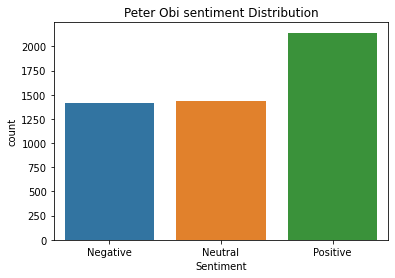

In [72]:
sent_dist(po_data_new,'Sentiment', "Peter Obi")

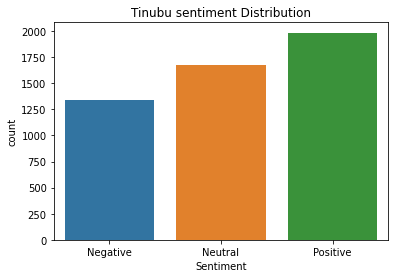

In [78]:
sent_dist(bat_data_new, 'Sentiment', 'Tinubu')

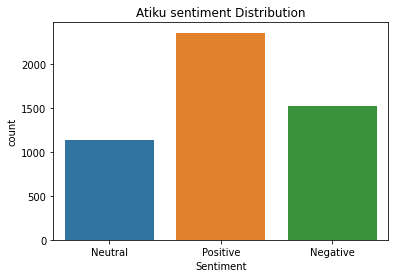

In [80]:
sent_dist(atiku_data_new, 'Sentiment', 'Atiku')

In [69]:
def wordclouder(data1, data2, col, sentiment, name):
    '''creates a wordcloud for each sentiment class'''
    plt.figure(figsize=(12,15))
    wcl  = WordCloud(max_words=2000,min_font_size=10, height=800, width=1600, background_color="black").generate(
        " ".join(data1[data2[col]==f'{sentiment}'].tweet))
    plt.title(f'Wordcloud of most common {sentiment} words for {name}')
    plt.imshow(wcl)

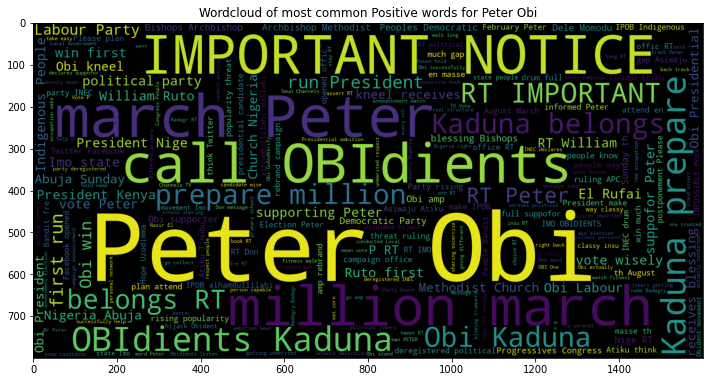

In [70]:
wordclouder(po_table, po_data_new, 'Sentiment', 'Positive', 'Peter Obi')

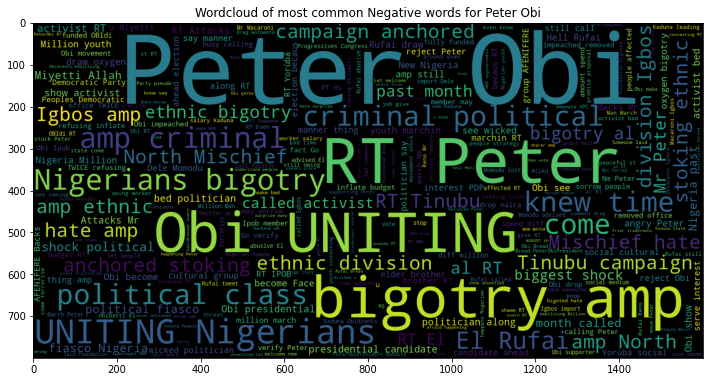

In [73]:
wordclouder(po_table, po_data_new, 'Sentiment', 'Negative', 'Peter Obi')

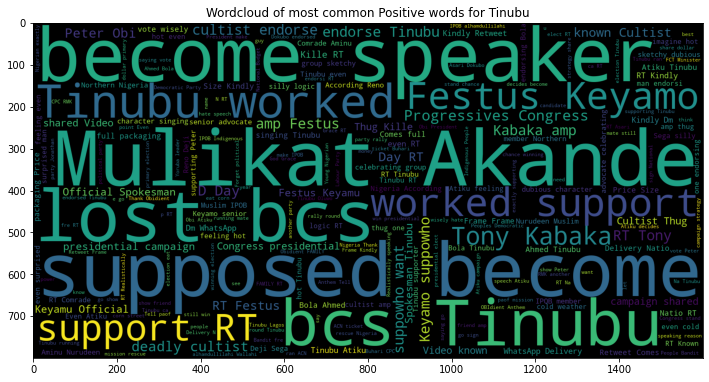

In [74]:
wordclouder(bat_table, bat_data_new, 'Sentiment', 'Positive', 'Tinubu')

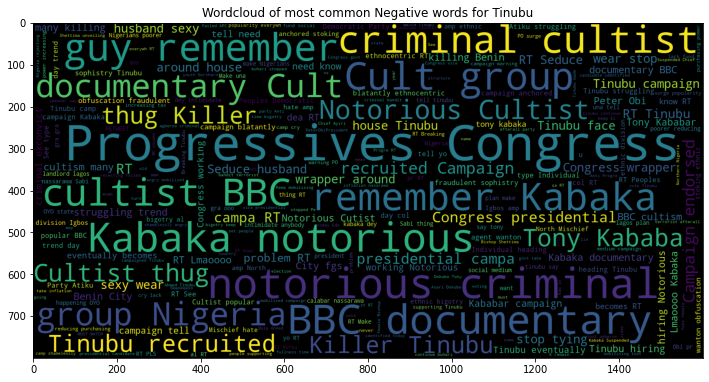

In [75]:
wordclouder(bat_table, bat_data_new, 'Sentiment', 'Negative', 'Tinubu')

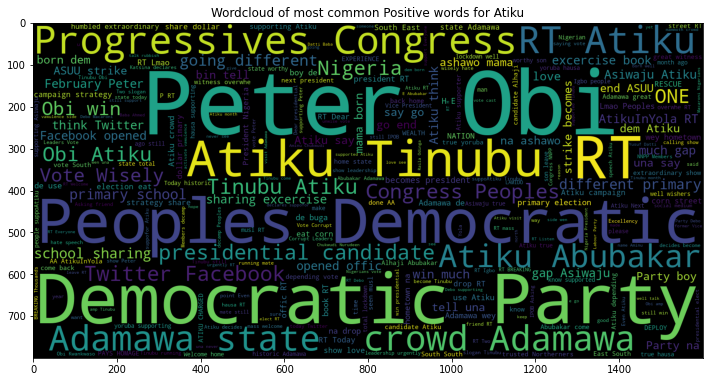

In [76]:
wordclouder(atiku_table, atiku_data_new, 'Sentiment', 'Positive', 'Atiku')

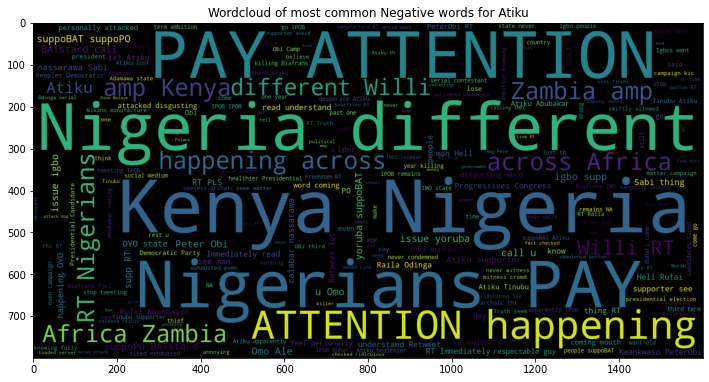

In [77]:
wordclouder(atiku_table, atiku_data_new, 'Sentiment', 'Negative', 'Atiku')

In [91]:
def table_(data1, data2):
    '''This function returns a merged table containing the sentiment scores, sentiment class and tweet variables'''
    data = pd.concat([data1.reset_index(drop=True), data2.drop(['id', 'name', 'location', 'time created','tweet url', 'source', 
    'retweet count', 'likes', 'tweet', 'neg', 'neu', 'pos'], axis=1)], axis = 1)
    return data

In [92]:
peter_obi = table_(po_table, po_data_new)

In [93]:
tinubu = table_(bat_table, bat_data_new)

In [94]:
atiku = table_(atiku_table, atiku_data_new)

In [102]:
#saving the datafrae as a csv file in local storage
def saver(data, data1):
    '''Saves the data table as a csv file in the directory'''
    return data.to_csv(f'{data1}.csv', sep ='\t', encoding='utf-8', header='True', index=False)

In [104]:
saver(peter_obi,'peter_obi')

In [103]:
saver(tinubu, 'tinubu')

In [105]:
saver(atiku, 'atiku')